## Retail Trade Sales

### Data Cleaning and Wrangling

In [61]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA

In [22]:
# Reading file

retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

In [23]:
# Renaming columns as per required
retailsales.rename(columns = {'REF_DATE':'DATE', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

In [24]:
# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['DATE'] >= '2004-01')]
retailsales_final = retailsales_filtered[['DATE', 'VALUE']].copy()

#Changing data type of date
retailsales_final['DATE'] =  pd.to_datetime(retailsales_final['DATE'])
retailsales_final = retailsales_final.set_index('DATE')
retailsales_final.head()

,VALUE
DATE,
2004-01-01,27935993.0
2004-02-01,28719948.0
2004-03-01,28689514.0
2004-04-01,28254086.0
2004-05-01,28554094.0


### Plotting Time Series Data

In [25]:
# plot

# retailsales_date=retailsales_final.set_index('DATE')

# plt.plot(retailsales_date)
# plt.show()

In [26]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

# plot_df(retailsales_final, 
#         x=retailsales_final.DATE, 
#         y=retailsales_final.VALUE, 
#         title='Retail Trade sales from 2004 to 2022')  

In [27]:
def plot_df_2(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

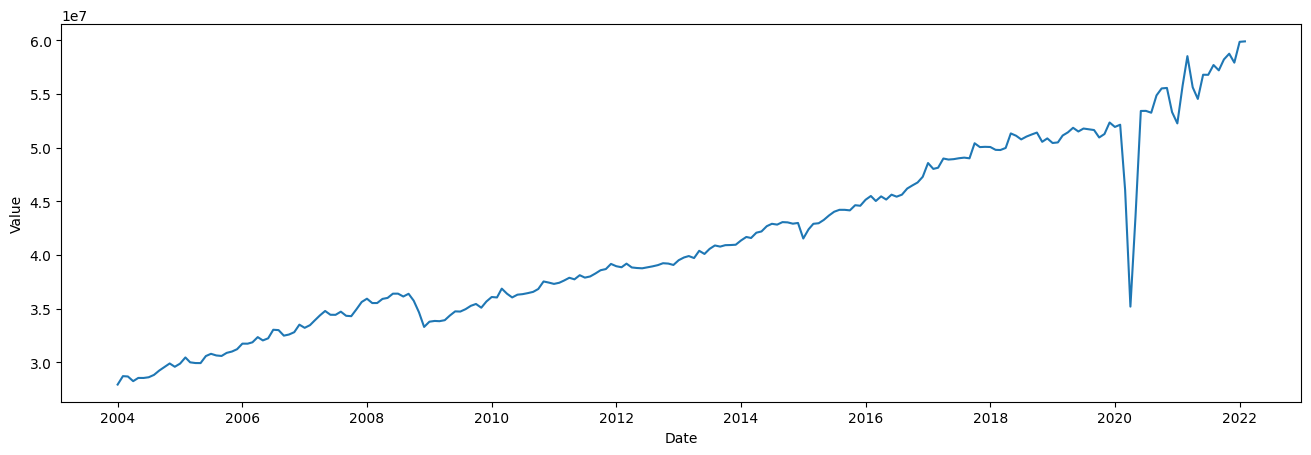

In [28]:
plot_df_2(retailsales_final['VALUE'])

### Cleaning and using Time Series Data

#### Adding column for growth rate

In [29]:
retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
#retailsales_final=retailsales_final.set_index()
retailsales_final = retailsales_final.dropna()
retailsales_final

,VALUE,GrowthRate
DATE,,
2004-02-01,28719948.0,0.028063
2004-03-01,28689514.0,-0.001060
2004-04-01,28254086.0,-0.015177
2004-05-01,28554094.0,0.010618
2004-06-01,28550528.0,-0.000125
...,...,...
2021-10-01,58218955.0,0.017790
2021-11-01,58750669.0,0.009133
2021-12-01,57919779.0,-0.014143


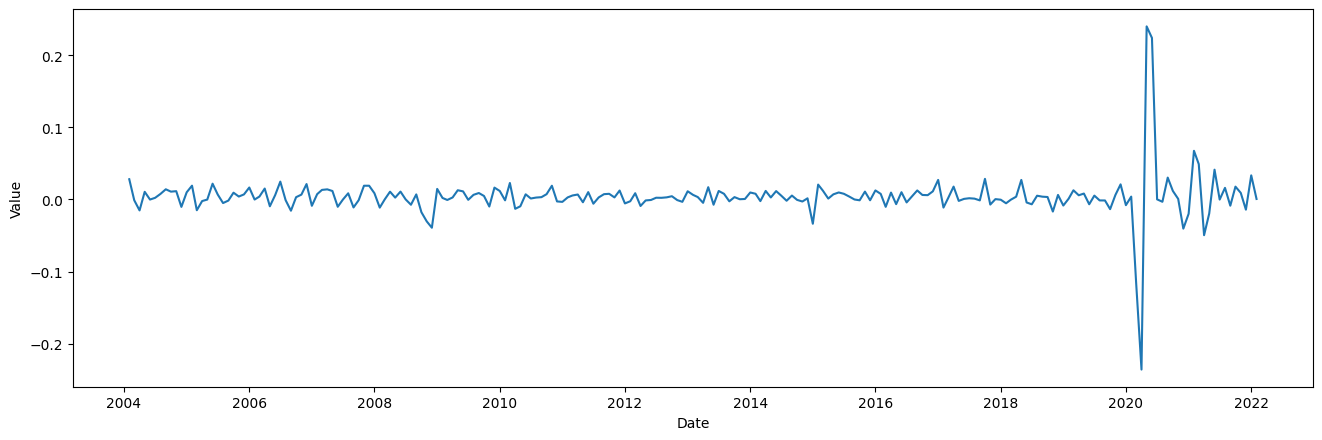

In [30]:
# Plot for growth rate
plot_df_2(retailsales_final['GrowthRate'])

#### Check for stationarity

In [31]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"

def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

In [32]:
adf_test(retailsales_final['GrowthRate'])

'Series is stationary'

In [33]:
kstest = kpss_test(retailsales_final['GrowthRate'])

/Users/aishwaryasharma/opt/miniconda3/envs/cap/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Calculating keywords using Google Trends

In [34]:
# Reading file for Categories
retailcat=pd.read_csv('../../data/keywords_data/RETAIL_SALES.csv')

In [35]:
retailcatdat = retailcat[['CatNo']].copy()

### Function to get the queries, topics and thus keywords using pytrends

In [36]:
pytrends = TrendReq(hl='en-US', tz=360, backoff_factor=0.1)

def get_trend(keyword=[''], category='0'):
    """ Function for getting trends for selected keywords
        
        arguments: 
        
        Keywords: data type is string: stores list of keywords
        category: data type is string: stores the code for category
        
        returns: google trend data, related queries and related topics as a data frame  
    """
    
    kw_list=keyword
    cat=category
    timeframe='2004-01-20 2022-01-01'
    geo ='CA'
    gprop =''
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    return data, queries, topics

In [19]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic


for index, row in retailcatdat.iterrows():
    
    #Calling function
    data, queries, topics = get_trend(keyword=[''],category=str(row['CatNo']))
    
    
    #Code to append data for different columns in data frame
    
    if index==0:
        FinalData, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        FinalData.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        FinalData=FinalData.drop(columns=['isPartial'])
    else:
        data, queries, topics=get_trend(keyword=[''],category=str(row['CatNo']))
        data.rename(columns = {'':str(row['CatNo'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['CatNo'])]
        FinalData = FinalData.join(data)
    
    #Code to store queries in a dictionary
    queries = queries['']['top']
    top5_query = pd.DataFrame(queries['query'].copy().head(5))
    top5_query = top5_query['query'].values.tolist()  
    keywordsDictQuery[str(row['CatNo'])] = top5_query
    
    #Code to store topics in a dictionary
    topics = topics['']['top']
    top5_topic = pd.DataFrame(topics['topic_title'].copy().head(5))
    top5_topic = top5_topic['topic_title'].values.tolist()
    keywordsDictTopic[str(row['CatNo'])] = top5_topic

In [20]:
FinalData

,841,47,1190,1191,1140,1213,1013,1214,806,810,...,355,1146,18,1225,270,659,1268,38,844,614
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,48,89,85,57,57,59,100,90,94,83,...,84,32,82,49,84,89,15,92,100,90
2004-03-01,44,94,69,77,67,64,83,93,97,86,...,91,29,81,50,88,89,23,93,79,87
2004-04-01,47,93,94,93,72,71,91,98,100,91,...,80,32,82,53,79,81,21,93,91,93
2004-05-01,48,94,65,96,73,76,91,89,100,97,...,78,33,80,50,74,81,43,92,88,68
2004-06-01,47,89,76,97,84,75,75,88,86,75,...,78,34,80,51,74,80,21,90,82,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,65,44,25,31,35,60,27,68,21,48,...,27,17,48,80,83,38,16,58,30,29
2021-10-01,65,43,25,26,26,47,26,64,20,59,...,24,21,50,83,86,40,26,55,29,37
2021-11-01,70,43,27,24,24,34,26,59,20,64,...,27,25,59,93,91,42,24,60,31,36


### Getting Google Trends Data for the Keywords (queries and topics)

In [37]:
def get_trends_for_dict(dict):
    i = 0
    for key, value in dict.items():
        category = key
        kw_lst = set(value)  # removes the repeated keywords
        for keyword in kw_lst:
            data, _, _ = get_trend(keyword=[keyword], category=category)

            # Code to append data for different keywords in data frame
            colname = category+"_"+keyword
            if len(data)==0:
                continue
            else:
                if i == 0:
                    data.rename(columns={keyword: colname}, inplace=True)
                    df = data.drop(columns=['isPartial'])
                else:
                    data.rename(columns={keyword: colname}, inplace=True)
                    data = data.drop(columns=['isPartial'])
                    df = df.join(data)
            i = i+1       
            
    return df

In [22]:
# For queries
keywords_query = get_trends_for_dict(keywordsDictQuery)
keywords_query

,841_walmart,841_superstore,841_costco,841_no frills,841_sobeys,47_nissan,47_honda,47_ford,47_toyota,47_dodge,...,844_barcode,844_rfid,844_pos,844_scanner,844_display,614_ticket,614_vancouver,614_centre bell,614_ticketmaster,614_cineplex
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,8,13,11,7,5,74,66,50,58,57,...,58,100,75,66,100,72,83,59,74,15
2004-03-01,10,13,11,4,6,80,87,62,69,65,...,43,93,74,94,91,60,73,60,56,33
2004-04-01,14,12,12,5,7,83,91,65,70,64,...,46,66,59,65,92,90,65,64,54,31
2004-05-01,10,14,13,6,7,79,91,59,73,61,...,66,76,74,57,94,44,67,25,42,23
2004-06-01,12,16,12,6,6,76,86,56,64,58,...,52,79,74,89,63,77,92,22,44,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,45,44,68,62,57,87,78,76,92,69,...,33,16,81,51,65,23,17,15,24,40
2021-10-01,46,47,72,58,59,81,73,77,95,69,...,36,16,70,59,71,26,21,29,30,55
2021-11-01,53,41,89,49,49,81,68,73,88,67,...,38,16,71,48,81,25,21,34,29,59


In [23]:
FinalData.to_csv('FinalRetailData_nonstationary.csv')
keywords_query.to_csv('keywords_query_nonstationary.csv')

In [25]:
# For Topics
keywords_topics = get_trends_for_dict(keywordsDictTopic)
keywords_topics

,841_Costco,841_Canada,841_Flyer,841_Real Canadian Superstore,841_No Frills,47_Sales,47_Car,47_Ford,47_Canada,47_Honda,...,38_Insurance,844_Point of sale,844_Canada,844_Barcode,844_Image scanner,614_Ticketmaster,614_Vancouver,614_Ticket,614_Centre Bell,614_Cineplex Entertainment
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,11,30,2,37,7,66,84,50,84,66,...,61,30,100,58,0,74,83,72,59,0
2004-03-01,11,28,3,30,4,77,88,62,94,87,...,67,83,25,43,0,56,73,60,60,0
2004-04-01,12,30,3,32,5,83,95,65,92,91,...,74,44,39,46,0,54,65,90,64,0
2004-05-01,13,36,3,36,6,86,100,59,96,91,...,73,85,75,66,0,42,67,44,25,0
2004-06-01,12,34,3,48,6,80,91,56,90,86,...,75,54,84,52,0,44,92,77,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,68,56,80,49,62,57,71,76,77,78,...,77,14,35,33,0,24,17,23,15,0
2021-10-01,72,60,80,56,58,53,67,77,72,73,...,72,11,33,36,0,30,21,26,29,0
2021-11-01,89,81,82,55,49,50,65,73,71,68,...,73,13,35,38,0,29,21,25,34,0


In [26]:
keywords_topics.to_csv('keywords_topics_nonstationary.csv')

### Checking if Data remains same every day

In [22]:
FinalData.to_csv('FinalRetailData2.csv')

In [23]:
retailsales1=pd.read_csv('../../src/notebooks/FinalRetailData.csv')
retailsales2=pd.read_csv('../../src/notebooks/FinalRetailData2.csv')

In [24]:
retailsales1 = retailsales1.set_index('date')
retailsales2 = retailsales2.set_index('date')

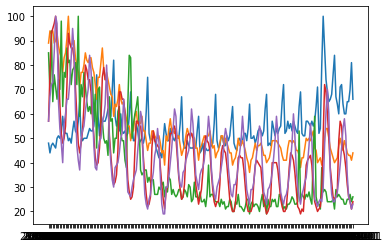

In [25]:
plt.plot(retailsales1[retailsales1.columns[0:5]])
plt.show()

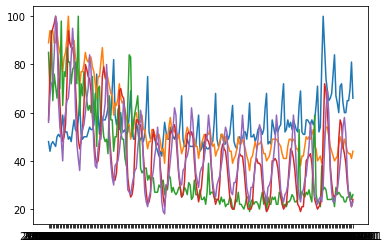

In [26]:
plt.plot(retailsales2[retailsales2.columns[0:5]])
plt.show()

### Storing data in data frame

In [27]:
FinalData.to_csv('FinalRetailData.csv')

### Storing queries and topics in json form

In [28]:
#Queries
with open('retail_queries.json', 'w') as fp:
    json.dump(keywordsDictQuery, fp,  indent=4)

In [29]:
#Topics
with open('retail_topics.json', 'w') as fp:
    json.dump(keywordsDictTopic, fp,  indent=4)

### Checking time series of the trends

In [30]:
retailtrends = pd.read_csv('../../src/notebooks/FinalRetailData.csv')
retailtrends = retailtrends.set_index(['date'])

In [31]:
kpss_test(retailtrends['47'])

/Users/aishwaryasharma/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


'Series is not stationary'

## Making time series stationary

#### Removing Trend

In [38]:
# function to get long term trend
# source link: statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


# function to normalize data

def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# function to get first difference (detrending)
def detrend(dataframe):
    return dataframe.diff().dropna()


# funtion to remove seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data


# funtion to remove volatility
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data


In [33]:
#temp = remove_downward_trend_bias(FinalData, FinalData, freq = 'M')
retail_timeseries = remove_seasonality(detrend(detrend(normalize(FinalData))))

In [34]:
retail_timeseries.head()

,841,47,1190,1191,1140,1213,1013,1214,806,810,...,355,1146,18,1225,270,659,1268,38,844,614
date,,,,,,,,,,,,,,,,,,,,,
2004-04-01,0.703590,-0.376481,2.059384,-0.313016,-0.436541,0.094229,1.600408,0.487099,0.013520,0.087180,...,-0.893435,0.969352,0.106286,0.128111,-1.011009,-0.384676,-1.008914,0.232413,1.833038,0.678154
2004-05-01,0.143209,0.522687,-2.456809,-0.149055,-0.377642,-0.005711,-0.439752,-0.594260,-0.062194,0.351950,...,0.533741,-0.323117,-0.017006,-0.023293,0.652264,0.448789,3.190351,0.073394,-0.851496,-1.353470
2004-06-01,0.049812,-0.500756,1.839828,0.196753,0.606306,-0.199880,-0.771368,0.501712,-0.638162,-1.588619,...,0.063817,-0.302667,0.076526,0.329983,0.239163,-0.099731,-5.126376,-0.154942,-0.120758,1.285371
2004-07-01,-0.342455,0.211999,-0.744825,0.011924,0.079686,0.251278,0.782181,-0.487099,0.827447,0.965441,...,-0.217557,0.229045,-0.204068,-0.023293,0.038049,-0.345496,1.833770,-0.232413,0.427296,-0.499393
2004-08-01,0.504343,0.343584,0.011117,-0.536598,-0.148978,0.539677,-0.173017,2.148105,-0.554336,0.213107,...,0.699084,0.339478,0.327359,-0.042704,0.217421,0.598385,0.477189,0.729859,-0.325117,-0.062424


In [35]:
retail_timeseries.to_csv('retailSales_timeseries.csv')

In [36]:
retail_Queries_timeseries = remove_seasonality(detrend(detrend(normalize(keywords_query))))

In [37]:
retail_Queries_timeseries.head()

,841_walmart,841_costco,841_sobeys,841_superstore,841_no frills,47_ford,47_dodge,47_toyota,47_nissan,47_honda,...,844_barcode,844_scanner,844_rfid,844_display,844_pos,614_vancouver,614_ticket,614_centre bell,614_cineplex,614_ticketmaster
date,,,,,,,,,,,,,,,,,,,,,
2004-04-01,-0.042582,0.056671,-0.096688,0.036491,0.077162,-0.594741,-0.584278,-0.321688,-0.060385,-1.242016,...,1.566146,-3.834819,-0.852714,1.479333,-0.805005,0.456595,2.144274,0.346270,0.011378,0.998568
2004-05-01,-0.223556,0.257854,0.070015,0.287363,0.125388,-0.393297,0.223400,0.485259,-0.301925,0.356237,...,0.914828,1.706425,1.372434,-1.029732,1.837604,0.294764,-3.468130,-1.896848,-0.762324,-0.800114
2004-06-01,0.489694,-0.096341,-0.020004,0.214382,0.016075,0.201445,-0.098812,-1.068660,0.080513,-0.168491,...,-2.262211,2.044928,0.093363,-2.277012,-0.746000,0.372789,3.468130,1.527663,0.682678,0.806414
2004-07-01,-0.223556,0.065172,0.080018,-0.323854,-0.221841,-0.124704,-0.373766,1.717489,0.231476,0.120350,...,0.606571,-3.357206,-0.566401,2.658931,0.627988,0.031788,-2.200212,-0.185866,-1.460931,-0.415807
2004-08-01,0.163231,-0.116176,0.273394,0.123156,0.253991,0.781797,0.940860,-1.881060,0.211348,0.139606,...,4.688494,2.443712,-0.224071,0.875030,-0.480474,-2.317651,0.362262,1.054087,1.722624,0.211054


In [38]:
retail_Queries_timeseries.to_csv('retail_Queries_timeseries.csv')

In [39]:
retail_Topics_timeseries = remove_seasonality(detrend(detrend(normalize(keywords_topics))))

In [40]:
retail_Topics_timeseries.to_csv('retail_Topics_timeseries.csv')

In [54]:
#check_stationarity(retail_timeseries)

In [55]:
#check_stationarity(retail_Queries_timeseries)

In [56]:
#check_stationarity(retail_Topics_timeseries)

## Reading stationary data and using that further for modelling

In [57]:
data = pd.read_csv('../../src/notebooks/retailSales_timeseries.csv')
queries = pd.read_csv('../../src/notebooks/retail_Queries_timeseries.csv')
topics = pd.read_csv('../../src/notebooks/retail_Topics_timeseries.csv')

In [58]:
data = data.set_index('date')
queries = queries.set_index('date')
topics = topics.set_index('date')

In [59]:
#check_stationarity(topics)

### Fitting ARIMA (Auto Regressive Integrated Moving Average) Model

#### For the data from Stats Canada web site

#### Checking acf and pacf plots

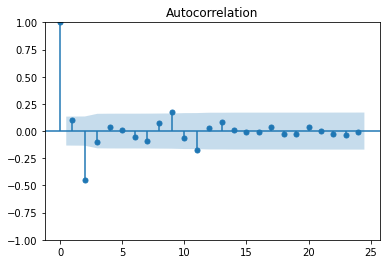

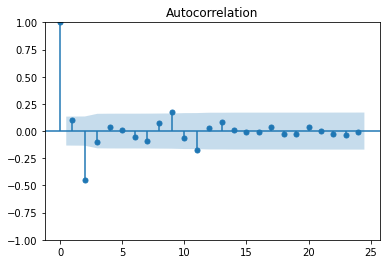

In [62]:
plot_acf(retailsales_final.GrowthRate)

/Users/aishwaryasharma/opt/miniconda3/envs/cap/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


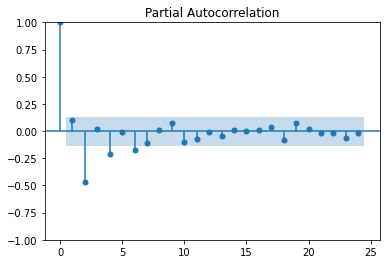

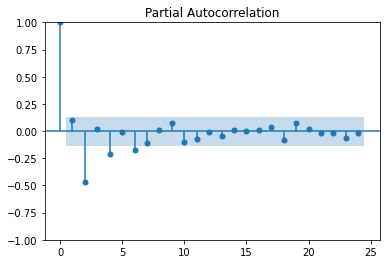

In [63]:
plot_pacf(retailsales_final.GrowthRate)

#### Since first significant lag is in second lag, hence p is 2 (from pacf) and q is 2 from acf. Since, we have already done the differencing , therefore, d = 0. ARIMA(p=2, d=0,q= 2).

In [64]:
arima_model_retail_stat = ARIMA(retailsales_final.GrowthRate, order = (2,0,2))
model = arima_model_retail_stat.fit()

/Users/aishwaryasharma/opt/miniconda3/envs/cap/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aishwaryasharma/opt/miniconda3/envs/cap/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aishwaryasharma/opt/miniconda3/envs/cap/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [65]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrowthRate   No. Observations:                  217
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 479.247
Date:                Wed, 18 May 2022   AIC                           -946.494
Time:                        11:24:53   BIC                           -926.215
Sample:                    02-01-2004   HQIC                          -938.302
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.369      0.001       0.002       0.006
ar.L1          0.2563      0.061      4.201      0.000       0.137       0.376
ar.L2         -0.1006      0.078     -1.292      0.196      -0.253       0.052
ma.L1         -0.1133      0.059     -1.936      0.053      -0.228       0.001
ma.L2         -0.5181      0.074     -6.981      0.000      -0.664      -0.373
sigma2         0.0007   1.95e-05     36.139      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11562.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              11.52   Skew:                            -1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Normalizing

In [44]:
# scaler = StandardScaler()
# scaler.fit(retailtrends)
# scaled_df = pd.DataFrame(scaler.transform(retailtrends))
# scaled_df

#### Taking difference

In [53]:
# scaled_df = scaled_df.diff().dropna()

In [45]:
#scaled_df

In [46]:
# plt.plot(scaled_df[1])
# plt.show()

#### Changing data as needed with proper index and column name

In [47]:
# scaled_df.index = FinalData.index
# scaled_df.columns = FinalData.columns
# scaled_df

In [128]:
# data, queries=get_trend(keyword=[''],category=str(retailcatdat['CatNo'].iloc[0]))
# queries = queries['']['top']
# top5 = pd.DataFrame(queries['query'].copy().head(5))
# top5 = top5['query'].values.tolist()
# keywordsDict = dict()
# keywordsDict[str(retailcatdat['CatNo'].iloc[0])] = top5
# keywordsDict

In [32]:
# from statsmodels.tsa.stattools import adfuller, kpss

# result = adfuller(retailsales_final.GrowthRate.values, autolag='AIC')

# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')

# # KPSS Test
# result = kpss(retailsales_final.GrowthRate.values, regression='c')

# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')
